## **LSTM for Cloud Resource Metrics Forecasting**

**The model is designed to forecast key AWS resource metrics (EC2, RDS, and ECS CPU utilization) by leveraging historical cloud monitoring data.**

1. Import libraries


Processing EC2 service

Processing EC2 data...
Loading data from ./dataset scripts/reduced_ec2_data.csv
Shape after preprocessing: (89831, 4)
Index has NaT: False
Dropped 3 rows containing NaN values in data columns
Performing feature importance analysis...
Top 10 most important features:
                      feature  importance
3    EC2_CPUUtilization_lag_1    0.593936
6   EC2_CPUUtilization_diff_1    0.389387
15         EC2_CPU_Disk_Ratio    0.005124
7   EC2_CPUUtilization_diff_3    0.005064
13       EC2_CPU_Memory_Ratio    0.004661
14      EC2_CPU_Network_Ratio    0.000839
1            EC2_DiskWriteOps    0.000426
0       EC2_MemoryUtilization    0.000338
2               EC2_NetworkIn    0.000088
10  EC2_CPUUtilization_std_6h    0.000012
Final DataFrame shape after feature selection: (89828, 16)
Index has NaT after cleaning: False
Training data shape: torch.Size([71843, 24, 16])
Validation data shape: torch.Size([17961, 24, 16])

Training EC2 LSTM model...
Epoch [1/100], Train Los

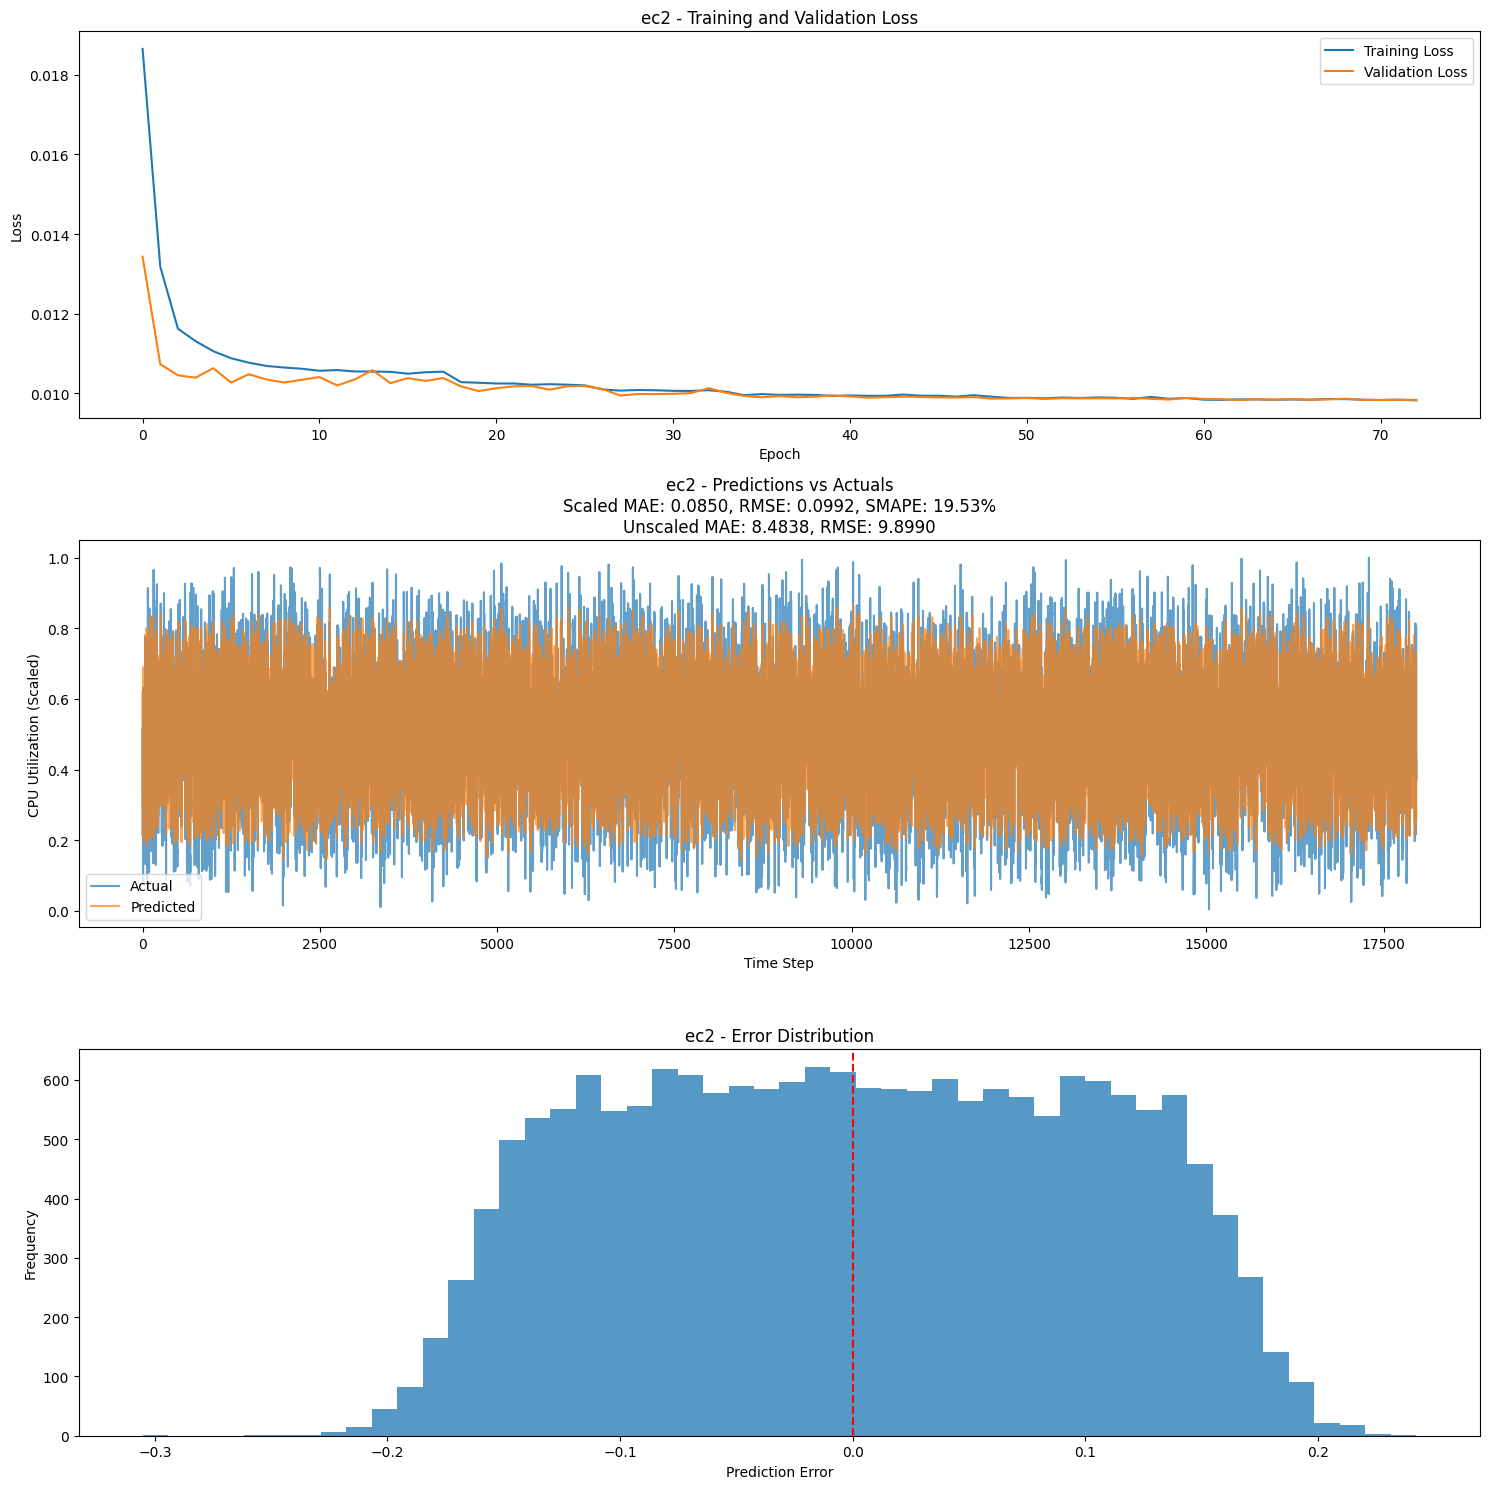

EC2 model saved as ec2_lstm_model_improved.pth

Demonstrating future predictions...


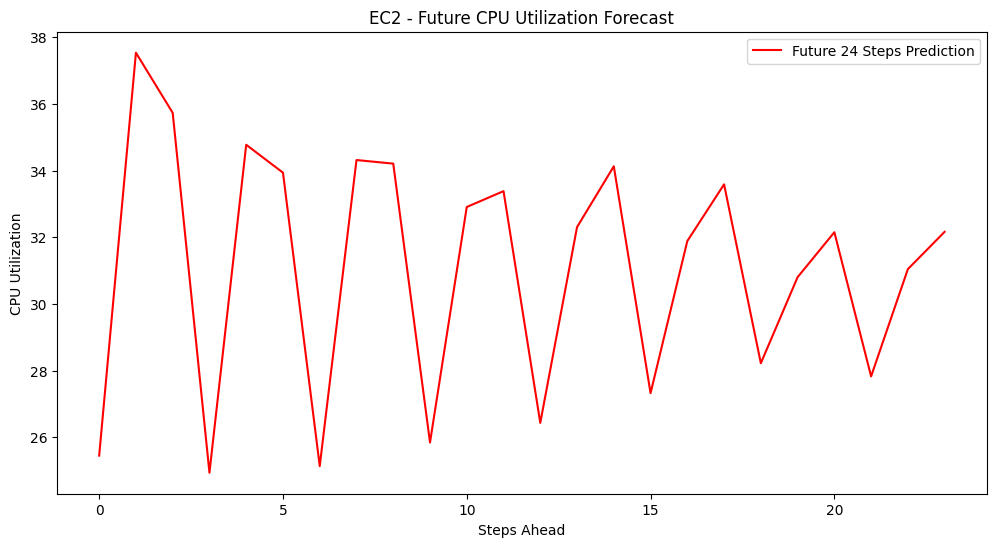


Completed EC2 processing


Processing RDS service

Processing RDS data...
Loading data from ./dataset scripts/reduced_rds_data.csv
Shape after preprocessing: (89943, 4)
Index has NaT: False
Dropped 3 rows containing NaN values in data columns
Performing feature importance analysis...
Top 10 most important features:
                      feature  importance
15         RDS_CPU_Conn_Ratio    0.496048
3    RDS_CPUUtilization_lag_1    0.274120
6   RDS_CPUUtilization_diff_1    0.215716
14       RDS_CPU_Memory_Ratio    0.009900
16           RDS_CPU_IO_Ratio    0.002220
1     RDS_DatabaseConnections    0.000963
13  RDS_Memory_Usage_Estimate    0.000400
0          RDS_FreeableMemory    0.000347
2               RDS_WriteIOPS    0.000218
10  RDS_CPUUtilization_std_6h    0.000005
Final DataFrame shape after feature selection: (89940, 16)
Index has NaT after cleaning: False
Training data shape: torch.Size([71932, 24, 16])
Validation data shape: torch.Size([17984, 24, 16])

Training RDS LSTM model.

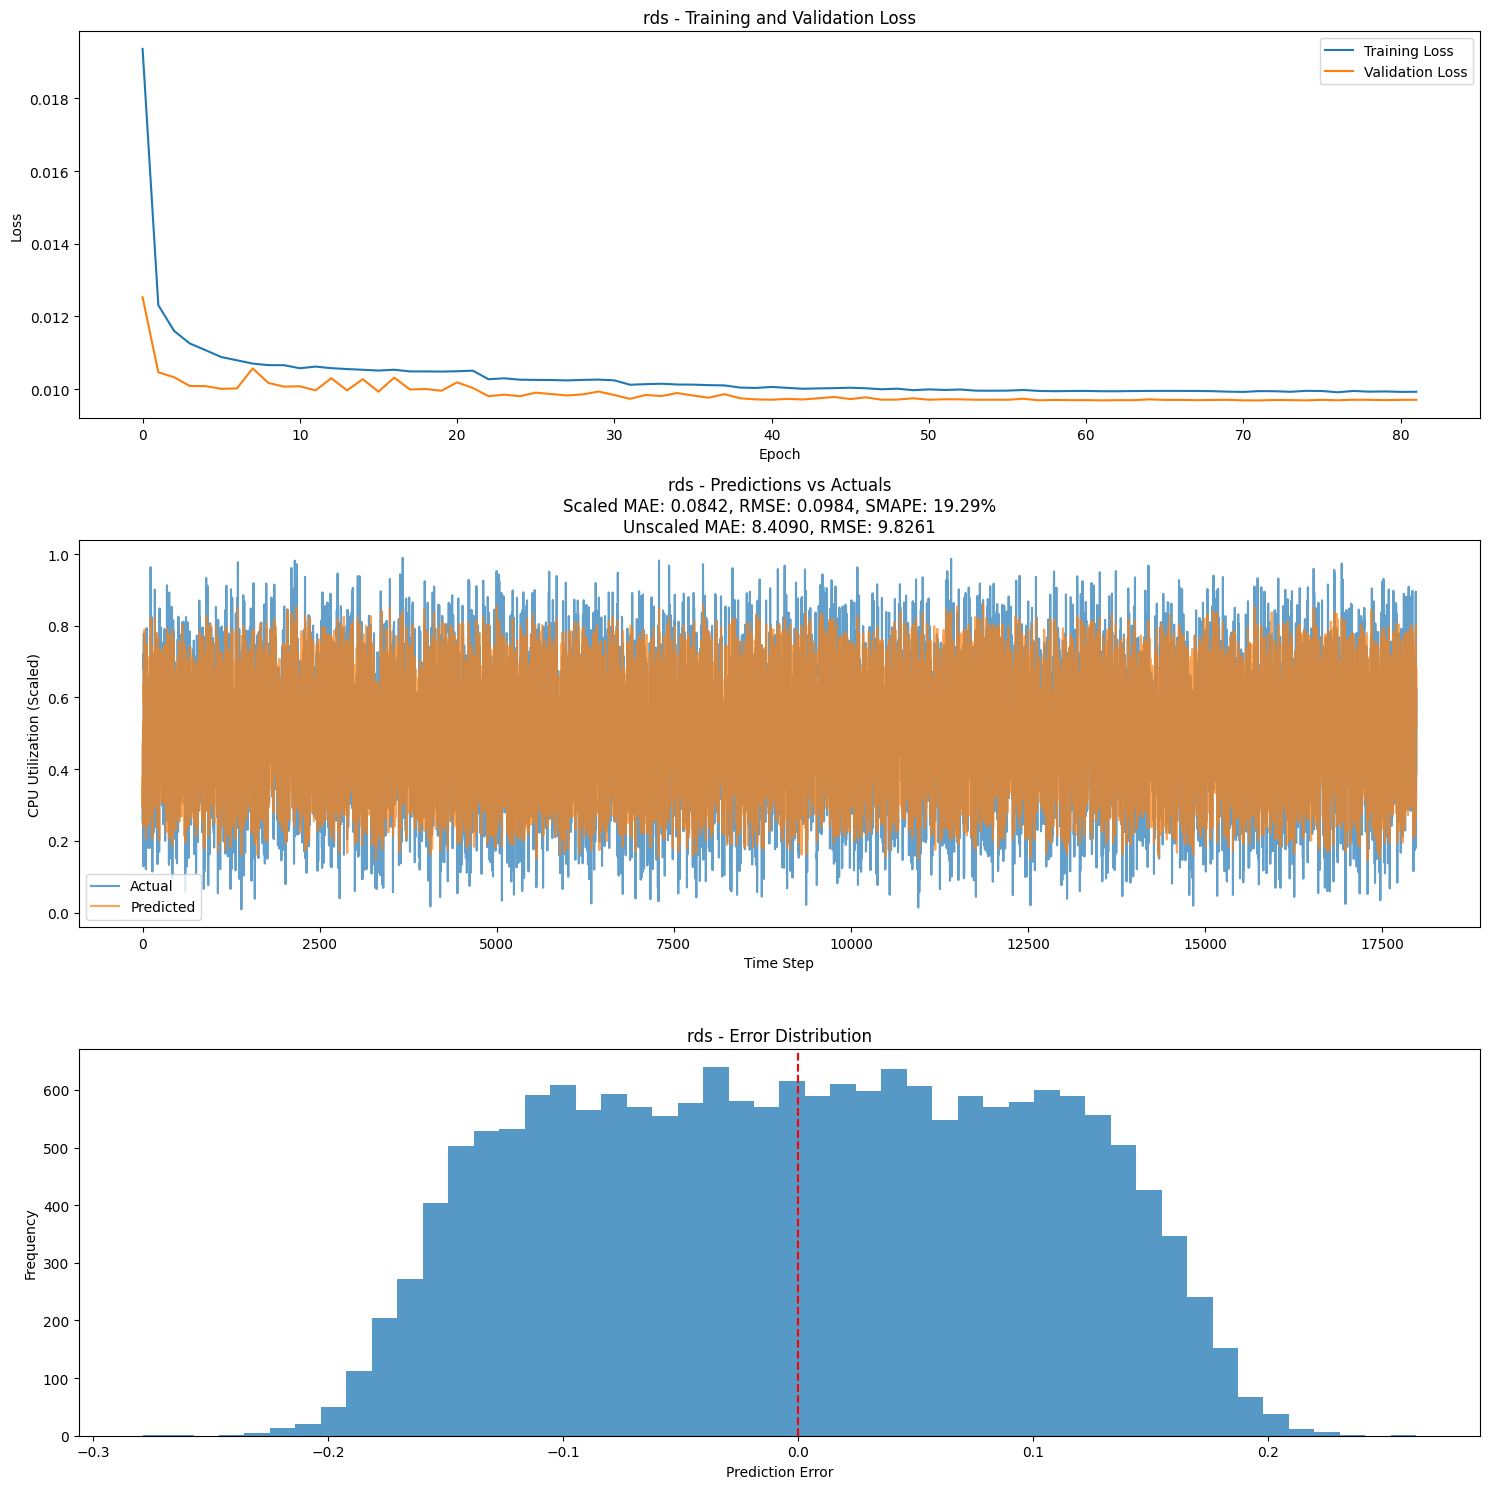

RDS model saved as rds_lstm_model_improved.pth

Demonstrating future predictions...


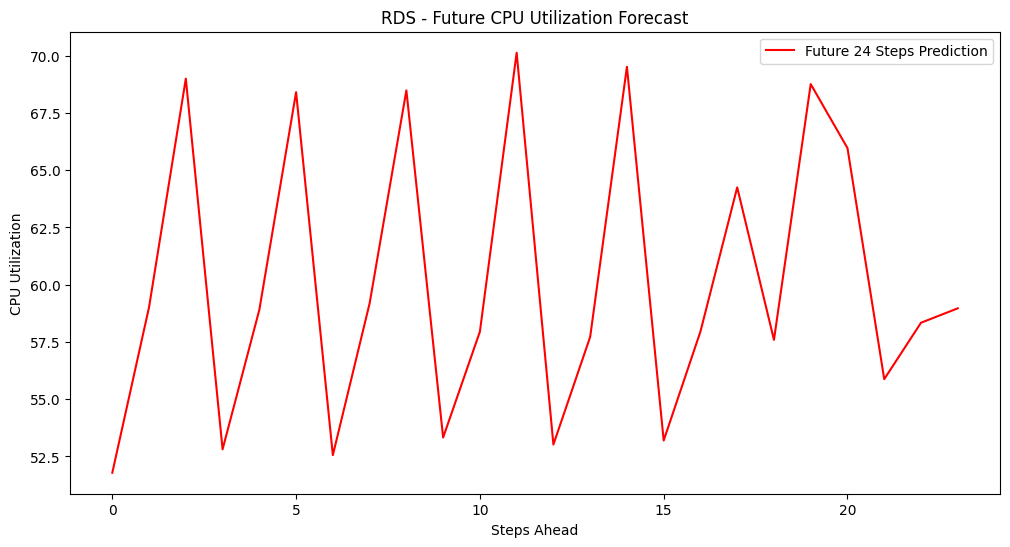


Completed RDS processing


Processing ECS service

Processing ECS data...
Loading data from ./dataset scripts/reduced_ecs_data.csv
Shape after preprocessing: (89846, 4)
Index has NaT: False
Dropped 3 rows containing NaN values in data columns
Performing feature importance analysis...
Top 10 most important features:
                       feature  importance
14          ECS_CPU_Task_Ratio    0.491013
3     ECS_CPUUtilization_lag_1    0.277936
6    ECS_CPUUtilization_diff_1    0.217513
15       ECS_CPU_Network_Ratio    0.007013
13        ECS_CPU_Memory_Ratio    0.005218
2                ECS_NetworkIn    0.000517
0        ECS_MemoryUtilization    0.000433
1         ECS_RunningTaskCount    0.000282
10   ECS_CPUUtilization_std_6h    0.000006
8   ECS_CPUUtilization_roll_6h    0.000006
Final DataFrame shape after feature selection: (89843, 16)
Index has NaT after cleaning: False
Training data shape: torch.Size([71855, 24, 16])
Validation data shape: torch.Size([17964, 24, 16])

Training ECS 

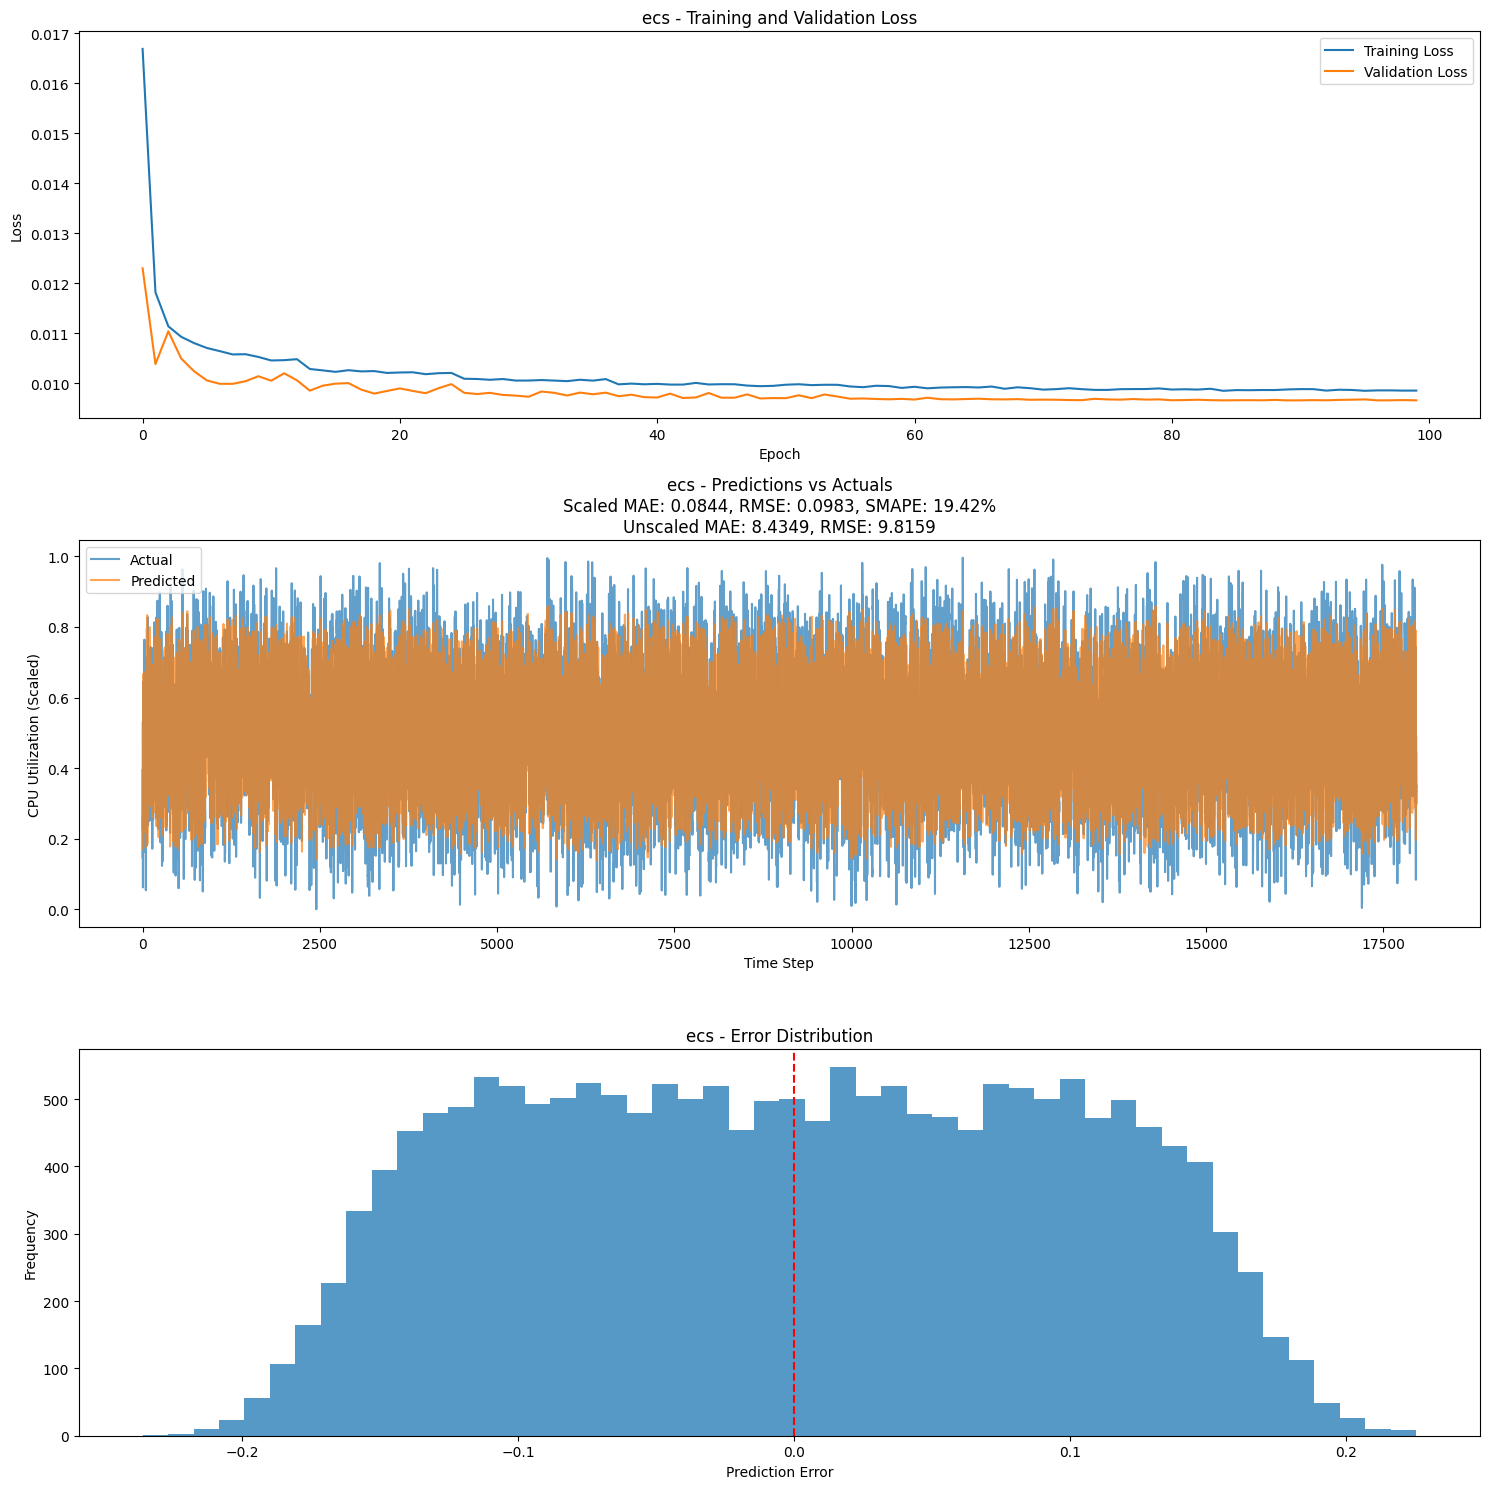

ECS model saved as ecs_lstm_model_improved.pth

Demonstrating future predictions...


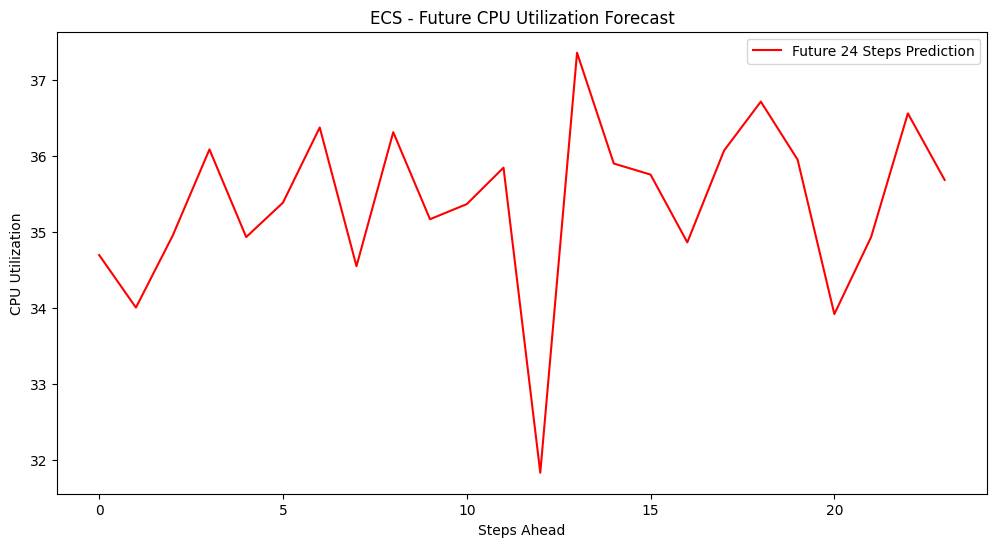


Completed ECS processing


The following models have been trained and saved successfully:
- EC2
- RDS
- ECS


In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Function to load and preprocess data with smoothing
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    print(f"Loading data from {file_path}")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    df = df.set_index('timestamp')
    df = df.sort_index()
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Apply light smoothing to the target columns to reduce noise
    for col in df.columns:
        if 'CPUUtilization' in col:
            df[col] = df[col].rolling(window=3, min_periods=1).mean()
    
    print(f"Shape after preprocessing: {df.shape}")
    print(f"Index has NaT: {df.index.isna().any()}")
    return df

# Feature engineering with feature importance analysis
def add_features(df, service_type):
    if service_type == 'ec2':
        cpu_col = 'EC2_CPUUtilization'
        memory_col = 'EC2_MemoryUtilization'
        network_col = 'EC2_NetworkIn'
        disk_col = 'EC2_DiskWriteOps'
    elif service_type == 'rds':
        cpu_col = 'RDS_CPUUtilization'
        memory_col = 'RDS_FreeableMemory'
        conn_col = 'RDS_DatabaseConnections'
        io_col = 'RDS_WriteIOPS'
    elif service_type == 'ecs':
        cpu_col = 'ECS_CPUUtilization'
        memory_col = 'ECS_MemoryUtilization'
        task_col = 'ECS_RunningTaskCount'
        network_col = 'ECS_NetworkIn'
    
    # Add lag features
    for i in range(1, 4):  # Reduced number of lags to avoid noise
        df[f'{cpu_col}_lag_{i}'] = df[cpu_col].shift(i)
    
    # Add differenced features
    df[f'{cpu_col}_diff_1'] = df[cpu_col].diff(1)
    df[f'{cpu_col}_diff_3'] = df[cpu_col].diff(3)
    
    # Add rolling averages
    df[f'{cpu_col}_roll_6h'] = df[cpu_col].rolling('6H', min_periods=1).mean()
    df[f'{cpu_col}_roll_24h'] = df[cpu_col].rolling('24H', min_periods=1).mean()
    
    # Add rolling standard deviations
    df[f'{cpu_col}_std_6h'] = df[cpu_col].rolling('6H', min_periods=1).std()
    
    # Add rolling quantiles
    df[f'{cpu_col}_q25'] = df[cpu_col].rolling('24H', min_periods=1).quantile(0.25)
    df[f'{cpu_col}_q75'] = df[cpu_col].rolling('24H', min_periods=1).quantile(0.75)
    
    # Calculate CPU to other resource ratios
    if service_type == 'ec2':
        df['EC2_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['EC2_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
        df['EC2_CPU_Disk_Ratio'] = df[cpu_col] / (df[disk_col] + 1e-8)
    elif service_type == 'rds':
        df['RDS_Memory_Usage_Estimate'] = 100 - (df[memory_col] / df[memory_col].max() * 100)
        df['RDS_CPU_Memory_Ratio'] = df[cpu_col] / (df['RDS_Memory_Usage_Estimate'] + 1e-8)
        df['RDS_CPU_Conn_Ratio'] = df[cpu_col] / (df[conn_col] + 1e-8)
        df['RDS_CPU_IO_Ratio'] = df[cpu_col] / (df[io_col] + 1e-8)
    elif service_type == 'ecs':
        df['ECS_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['ECS_CPU_Task_Ratio'] = df[cpu_col] / (df[task_col] + 1e-8)
        df['ECS_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
    
    # Add time-based features with cyclical encoding
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    
    # Drop rows with NaN values
    original_len = len(df)
    df = df.dropna()
    print(f"Dropped {original_len - len(df)} rows containing NaN values in data columns")
    
    if df.index.isna().any():
        print(f"Found NaT in index. Cleaning index...")
        df = df[~df.index.isna()]
        print(f"Dropped rows with NaT in index. New shape: {df.shape}")
    
    # Feature importance analysis using RandomForest
    print("Performing feature importance analysis...")
    X = df.drop(columns=[cpu_col])
    y = df[cpu_col]
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X, y)
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values(by='importance', ascending=False)
    print("Top 10 most important features:")
    print(importance.head(10))
    
    # Select top 15 features to reduce noise
    top_features = importance['feature'].head(15).values
    selected_columns = list(top_features) + [cpu_col]
    df = df[selected_columns]
    
    print(f"Final DataFrame shape after feature selection: {df.shape}")
    print(f"Index has NaT after cleaning: {df.index.isna().any()}")
    return df

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Updated LSTM Model with increased capacity
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                           dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attn_weights = self.attention(lstm_out)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(lstm_out * attn_weights, dim=1)
        out = self.fc1(context)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Data preparation with reduced sequence length
def prepare_data_for_lstm(df, target_col, sequence_length=24):  # Reduced from 48 to 24
    if df.index.isna().any():
        raise ValueError("Index contains NaT values. Please clean the DataFrame before proceeding.")
    
    target_data = df[target_col].values.reshape(-1, 1)
    feature_scaler = RobustScaler()
    target_scaler = MinMaxScaler()
    scaled_target = target_scaler.fit_transform(target_data)
    df_scaled = df.copy()
    df_scaled[target_col] = scaled_target.flatten()
    scaled_data = feature_scaler.fit_transform(df_scaled)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_target[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    return X_train, y_train, X_test, y_test, feature_scaler, target_scaler

# Use standard MSE loss instead of AsymmetricMSELoss
criterion = nn.MSELoss()

# Training function with lower learning rate
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        if scheduler:
            scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_{epoch}.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(torch.load(f'best_model_{epoch-patience}.pth'))
                break
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return model, train_losses, val_losses

# Updated evaluation function with SMAPE and unscaled metrics
def evaluate_model(model, test_loader, criterion, target_scaler):
    model.eval()
    predictions = []
    actuals = []
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Compute metrics on scaled data
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)**2))
    smape = np.mean(2 * np.abs(predictions - actuals) / (np.abs(predictions) + np.abs(actuals) + 1e-8)) * 100
    
    # Compute metrics on unscaled data
    actuals_unscaled = target_scaler.inverse_transform(actuals)
    predictions_unscaled = target_scaler.inverse_transform(predictions)
    mae_unscaled = np.mean(np.abs(predictions_unscaled - actuals_unscaled))
    rmse_unscaled = np.sqrt(np.mean((predictions_unscaled - actuals_unscaled)**2))
    
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Scaled - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape:.4f}%")
    print(f"Unscaled - MAE: {mae_unscaled:.4f}, RMSE: {rmse_unscaled:.4f}")
    
    return avg_test_loss, predictions, actuals, {'mae': mae, 'rmse': rmse, 'smape': smape, 'mae_unscaled': mae_unscaled, 'rmse_unscaled': rmse_unscaled}

# Updated plotting function
def plot_results(train_losses, val_losses, predictions, actuals, service_name, metrics):
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{service_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title(f'{service_name} - Predictions vs Actuals\nScaled MAE: {metrics["mae"]:.4f}, RMSE: {metrics["rmse"]:.4f}, SMAPE: {metrics["smape"]:.2f}%\nUnscaled MAE: {metrics["mae_unscaled"]:.4f}, RMSE: {metrics["rmse_unscaled"]:.4f}')
    plt.xlabel('Time Step')
    plt.ylabel('CPU Utilization (Scaled)')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    errors = predictions - actuals
    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{service_name} - Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(f'{service_name}_improved_results.png')
    plt.show()

# Updated forecasting function
def forecast_future(model, last_sequence, feature_scaler, target_scaler, steps_ahead=24, original_df=None):
    model.eval()
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
    future_predictions = []
    current_sequence = last_sequence_tensor.clone()
    
    with torch.no_grad():
        for _ in range(steps_ahead):
            next_pred = model(current_sequence)
            future_predictions.append(next_pred.item())
            new_sequence = current_sequence.clone()
            new_sequence[0, :-1, :] = current_sequence[0, 1:, :]
            new_sequence[0, -1, 0] = next_pred.item()
            current_sequence = new_sequence
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    dummy = np.zeros((len(future_predictions), 1))
    dummy[:, 0] = future_predictions[:, 0]
    future_predictions_original = target_scaler.inverse_transform(dummy)
    return future_predictions_original.flatten()

# Main pipeline function
def run_lstm_pipeline(file_path, service_type, target_col):
    print(f"\nProcessing {service_type.upper()} data...")
    
    try:
        df = load_and_preprocess(file_path)
        df = add_features(df, service_type)
        X_train, y_train, X_val, y_val, feature_scaler, target_scaler = prepare_data_for_lstm(df, target_col)
        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        
        train_dataset = TimeSeriesDataset(X_train, y_train)
        val_dataset = TimeSeriesDataset(X_val, y_val)
        batch_size = min(64, len(train_dataset) // 100)
        batch_size = max(16, batch_size)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        input_size = X_train.shape[2]
        hidden_size = 256  # Increased from 128
        num_layers = 3     # Increased from 2
        output_size = 1
        dropout_rate = 0.3
        model = AttentionLSTM(input_size, hidden_size, num_layers, output_size, dropout_rate)
        
        criterion = nn.MSELoss()  # Using standard MSE loss
        optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Reduced learning rate
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
        
        print(f"\nTraining {service_type.upper()} LSTM model...")
        num_epochs = 100
        patience = 10
        model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, patience)
        
        print(f"\nEvaluating {service_type.upper()} LSTM model...")
        test_loss, predictions, actuals, metrics = evaluate_model(model, val_loader, criterion, target_scaler)
        plot_results(train_losses, val_losses, predictions, actuals, service_type, metrics)
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'metrics': metrics,
            'sequence_length': 24,
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers
        }, f'{service_type}_lstm_model_improved.pth')
        
        print(f"{service_type.upper()} model saved as {service_type}_lstm_model_improved.pth")
        
        print("\nDemonstrating future predictions...")
        last_sequence = X_val[-1].numpy()
        future_steps = 24
        future_preds = forecast_future(model, last_sequence, feature_scaler, target_scaler, steps_ahead=future_steps)
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(future_steps), future_preds, 'r-', label=f'Future {future_steps} Steps Prediction')
        plt.title(f'{service_type.upper()} - Future CPU Utilization Forecast')
        plt.xlabel('Steps Ahead')
        plt.ylabel('CPU Utilization')
        plt.legend()
        plt.savefig(f'{service_type}_future_forecast.png')
        plt.show()
        
        return model, (feature_scaler, target_scaler)
    
    except Exception as e:
        print(f"ERROR processing {service_type}: {str(e)}")
        return None, None

# Run the pipeline for each service
if __name__ == "__main__":
    services = [
        {'file': './dataset scripts/reduced_ec2_data.csv', 'type': 'ec2', 'target': 'EC2_CPUUtilization'},
        {'file': './dataset scripts/reduced_rds_data.csv', 'type': 'rds', 'target': 'RDS_CPUUtilization'},
        {'file': './dataset scripts/reduced_ecs_data.csv', 'type': 'ecs', 'target': 'ECS_CPUUtilization'}
    ]
    
    models = {}
    scalers = {}
    
    for service in services:
        print(f"\n{'='*50}")
        print(f"Processing {service['type'].upper()} service")
        print(f"{'='*50}")
        
        model, scaler = run_lstm_pipeline(service['file'], service['type'], service['target'])
        if model is not None:
            models[service['type']] = model
            scalers[service['type']] = scaler
            print(f"\nCompleted {service['type'].upper()} processing\n")
        else:
            print(f"\nFailed to process {service['type'].upper()}\n")
    
    if models:
        print("\nThe following models have been trained and saved successfully:")
        for service_type in models.keys():
            print(f"- {service_type.upper()}")
    else:
        print("\nNo models were successfully trained.")

## **LSTM for Cloud Resource Metrics Forecasting**

**The model is designed to forecast key AWS resource metrics (EC2, RDS, and ECS CPU utilization) by leveraging historical cloud monitoring data.**